In [4]:
import string
import math
import requests
import time

import scipy as sp
from scipy.stats import norm
from scipy.integrate import quad

import random as rd
import numpy as np
import pandas as pd
import seaborn as sns

from concurrent.futures import ThreadPoolExecutor
import requests
from requests.exceptions import ConnectionError

# Questão 1

A fim de verificar a resposta analítica, fiz um algoritmo de Monte Carlo para o cálculo do estimador de P\[Z>=10\]

In [5]:
n = 100000 # Número de amostras
list_z = []
for i in range(n):
    z = 1
    while True:
        resultado_dado = rd.randint(1, 20)
        if resultado_dado in (2, 3, 5, 7, 11, 13, 17, 19):  # testa se o resultado do dado é primo
            break
        else:
            z+=1
    list_z.append(z)

list_z_10 = [z for z in list_z if z >= 10]  # filtra os resultados onde z>=10
p_z_10 = len(list_z_10)/len(list_z)  # estimador de Monte Carlo para P[z>=10]

print(p_z_10)

0.01043


# Questão 2

Calculei o estimador da chance de acertar a moeda escolhida para n = \[1,...,100\], com base na fórmula encontrada analiticamente.
A acurácia foi calculada para todo n variando de 0 a 100.
Para n=38, a acurácia foi de 0.9468 e para n=39, foi 0.9510.
Logo, com n=39, temos mais que 95% de chance de acertar a moeda correta.

In [10]:
dict_total = dict()
for n in range(100):
    s_1 = int(np.floor(n*np.log(2)/np.log(3)))
    s_2 = int(np.ceil(n*np.log(2)/np.log(3)))

    total = 0
    for i in range(s_1+1):  # Calcula a probabilidade do estimador acertar e a moeda ser honesta
        comb = sp.special.comb(n, i)  # combinação de n, i a i.
        total_local = (2**n/(2**n+3**i)*(comb*(2**(-n)+(3/4)**i*(1/4)**(n-i))/2))
        total += total_local

    for i in range(s_2, n+1):  # Calcula a probabilidade do estimador acertar e a moeda ser enviesada
        comb = sp.special.comb(n, i)
        total_local = (3**i/(2**n+3**i)*(comb*(2**(-n)+(3/4)**i*(1/4)**(n-i))/2))
        total += total_local
    dict_total[n] = total
    
print(dict_total[39])

0.9510351888769604


Criei um estimador de Monte Carlo para validar a fórmula da acurácia do estimador criado, encontrada analiticamente , para n=39

In [11]:
n = 39
n_trials = 10000

threshold = n*np.log(2)/np.log(3)

lista_soma_honesto = []
lista_soma_enviesado = []
acertos_honesto = 0
acertos_enviesado = 0

for i in range(n_trials):
    if rd.random() < 0.5:
        honesto = rd.choices((1,0), weights=(0.5, 0.5), k=n)
        soma_local = sum(honesto)
        lista_soma_honesto.append(soma_local)
        if soma_local < threshold:
            acertos_honesto += 1
    else:
        enviesado = rd.choices((1,0), weights=(0.75, 0.25), k=n)
        soma_local = sum(enviesado)
        lista_soma_enviesado.append(soma_local)
        if soma_local > threshold:
            acertos_enviesado += 1

acertos = acertos_honesto + acertos_enviesado
freq_acertos = acertos/n_trials
print("freq_acertos: " + str(freq_acertos))

freq_acertos: 0.9506


Fiz um histograma de S_n, para ver graficamente a distribuição de S_n como uma soma de binomiais.

<Axes: xlabel='S_n', ylabel='Count'>

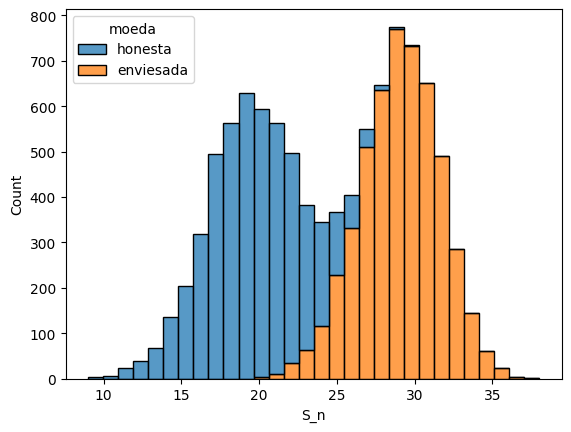

In [15]:
df_honesto = pd.DataFrame({"moeda": ["honesta"]*len(lista_soma_honesto), "S_n": lista_soma_honesto})
df_enviesado = pd.DataFrame({"moeda": ["enviesada"]*len(lista_soma_enviesado), "S_n": lista_soma_enviesado})

df_moedas = pd.concat([df_honesto, df_enviesado])

sns.histplot(data=df_moedas, x="S_n", hue="moeda", multiple="stack", bins=30)

# Questão 3

Valor da inversa da normal no ponto 0.95, utilizada no calculo do estimador de P\[Z>=74\]

In [16]:
norm.ppf(0.95)

1.6448536269514722

Criei um algoritmo de Monte Carlo para validar que P\[Z>=74\] = 0.05% e validar as contas analíticas

In [18]:
list_s = []
for i in range(10000):
    sanduiches = 0
    for i in range(64):
        sanduiches += np.random.choice([0, 1, 2], p=[1/4, 1/2, 1/4])
    list_s.append(sanduiches)

In [20]:
list_s_74 = [s for s in list_s if s > 74]  # filtra os resultados onde z>139
p_s_74 = len(list_s_74)/len(list_s)  # estimador de Monte Carlo para P[z>=139]

print(p_s_74)

0.0291


<Axes: xlabel='S_n', ylabel='Count'>

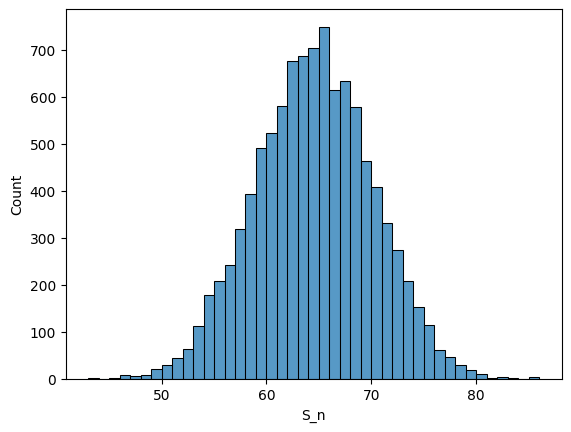

In [27]:
# O histograma de S_n sugere que a distribuição de S_n converge para uma normal

df_sandubas = pd.DataFrame({"S_n": list_s})
sns.histplot(data=df_sandubas, x="S_n", multiple="stack", bins=43)

# Questão 5

"Seja X_i uma sequência i.i.d. de v.a. contínuas uniformes em \[0, 1\]. Seja V o menor número k tal que a soma das primeiras k variáveis seja maior do que 1. Ou seja, V = min{k ┤| X_1+⋯+X_k≥1}."

### Ponto 1

Algoritmo que gera uma amostra de V

In [28]:
def gerar_amostra_v():
    v = 0
    soma_uniformes = 0
    while True:
        soma_uniformes += rd.random()
        v+= 1
        if soma_uniformes > 1:
            return v

gerar_amostra_v()

2

### Ponto 2

Algoritmo de Monte Carlo que estima o valor esperado de V

In [30]:
def valor_esperado_v(n):
    v_soma = 0
    for i in range(n):
        v_soma += gerar_amostra_v()
    return v_soma/n

valor_esperado_v(100)

2.72

### Ponto 3

Gráfico do valor estimado em função do número de amostras, para n = \[1, 5, 10, ..., 50000]

In [31]:
def valores_estimados_v(n, passo):
    list_n = []
    list_freq_v = []
    for i in range(n):
        n_local = (i+1)*passo
        freq_v = valor_esperado_v(n_local)
        list_n.append(n_local)
        list_freq_v.append(freq_v)
    return pd.DataFrame({"n":list_n,"freq": list_freq_v})

In [34]:
df_v = valores_estimados_v(10000, 5)
print(df_v)

          n      freq
0         5  2.600000
1        10  2.300000
2        15  2.666667
3        20  2.750000
4        25  2.760000
...     ...       ...
9995  49980  2.718647
9996  49985  2.723037
9997  49990  2.721044
9998  49995  2.716712
9999  50000  2.722560

[10000 rows x 2 columns]


<Axes: xlabel='n', ylabel='freq'>

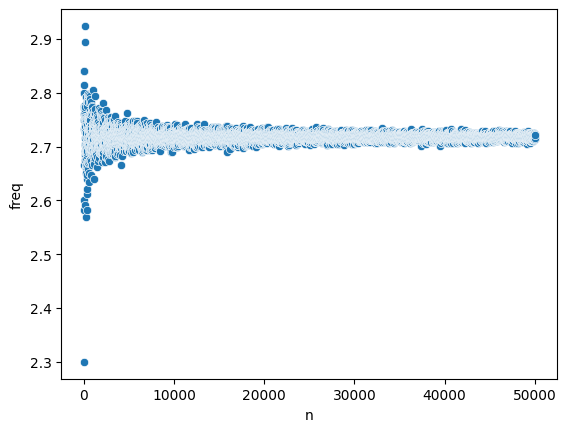

In [35]:
sns.scatterplot(data = df_v, x="n", y="freq")

V parece se aproximar do número neperiano.

# Questão 7

### Ponto 2

Método de Monte Carlo para gerar amostras e estimar quantos domínios existem
 dentro do padrão de nomes http://www.[a-z](k).ufrj.br, onde \[a-z\](k) é qualquer sequência de caracteres de comprimento k ou menor

In [37]:
def checar_dominio(domain):
    try:
        response = requests.head(domain, timeout=10)
    except (ConnectionError, requests.exceptions.Timeout):
        return 0
    else:
        return 1


def checar_dominios(list_domain):
    with ThreadPoolExecutor() as executor:
        gen_map = executor.map(checar_dominio, list_domain)
    return sum(gen_map)


def gerar_dominio(k):
    global list_letras
    return "http://www." + ''.join(rd.choices(list_letras, k=k)) + ".ufrj.br"


def gerar_dominios(k, n):
    with ThreadPoolExecutor() as executor:
        gen_map = executor.map(gerar_dominio, [k]*n)
        return list(gen_map)


def estimar_dominios(k, n_amostras):
    soma_x = 0
    lista_dominios = gerar_dominios(k, n_amostras)
    soma_x += checar_dominios(lista_dominios)

    media_x = soma_x/n_amostras
    n_total = 26*27**(k-1)
    estimador = media_x * n_total
    
    return estimador

In [38]:
list_letras = list(string.ascii_lowercase) + [""]

In [62]:
list_n = []
list_estimadores = []
for i in range(100):
    n_local = 1 + 100*(i)
    estimador = estimar_dominios(4, n_local)
    print("Estimador para n=" + str(n_local) + " é " + str(estimador))
    list_n.append(n_local)
    list_estimadores.append(estimador)

Estimador para n=1 é 0.0
Estimador para n=101 é 5066.910891089109
Estimador para n=201 é 5092.119402985075
Estimador para n=301 é 0.0
Estimador para n=401 é 0.0
Estimador para n=501 é 1021.4730538922155
Estimador para n=601 é 0.0
Estimador para n=701 é 0.0
Estimador para n=801 é 638.8988764044944
Estimador para n=901 é 0.0
Estimador para n=1001 é 511.24675324675326
Estimador para n=1101 é 0.0
Estimador para n=1201 é 1278.3297252289758
Estimador para n=1301 é 0.0
Estimador para n=1401 é 0.0
Estimador para n=1501 é 0.0
Estimador para n=1601 é 319.64896939412864
Estimador para n=1701 é 601.7142857142857
Estimador para n=1801 é 568.3042754025541
Estimador para n=1901 é 538.4092582851131
Estimador para n=2001 é 511.5022488755622
Estimador para n=2101 é 243.57829604950024
Estimador para n=2201 é 0.0
Estimador para n=2301 é 444.81355932203394
Estimador para n=2401 é 213.14369012911288
Estimador para n=2501 é 409.2427029188325
Estimador para n=2601 é 983.7716262975779
Estimador para n=2701 é 0

In [63]:
df_estimadores = pd.DataFrame({"n": list_n, "estimador": list_estimadores})

<Axes: xlabel='n', ylabel='estimador'>

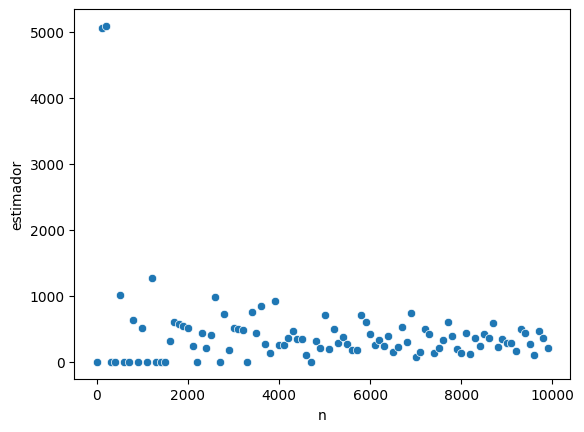

In [64]:
sns.scatterplot(data = df_estimadores, x="n", y="estimador")

No experimento realizado, o estimador de w_n não parece convergir.
O motivo disso é que, como N, o número domínios possíveis, é muito grande e P\[X\] é muito pequeno,
o valor do estimador muda bruscamente com pequenas alterações no número de casos encontrados na amostra.

# Questão 8

A fim de validar as contas feitas analiticamente, implementei os geradores de amostras por Rejection Sampling desenvolvidos nos pontos 1 e 2 da lista. 

### Ponto 1

In [57]:
def f(x):
    comb = sp.special.comb(1000, x)
    return comb*0.2**x*0.8**(1000-x)

def amostra_f_unif():
    while True:
        a_1 = rd.randint(1, 1000)
        a_2 = rd.random()*0.031525361  # como g(x) é uniforme, c*g(x) é sempre igual a 0.031525361
        f_a_1 = f(a_1)
        if a_2 <= f_a_1:
            return a_1

### Ponto 2

In [76]:
def g(x):
    if x < 174:
        return 1/1521.316251
    elif x < 227:
        return 1/151.725297
    else:
        return 1/1443.195636

def G_inv(x):
    if x < 0.120966:
        return x*1521.316251-1
    elif x < 0.464382:
        return (x-0.114375)*151.725297+173
    else:
        return (x-0.46369)*1443.195636+226

def amostra_g():
    return math.floor(G_inv(rd.random()))+1

In [77]:
def amostra_f_nova():
    amostra = None
    while True:
        a_1 = amostra_g()
        a_2 = rd.random()*4.78314*g(a_1)  # como g(x) é uniforme, c*g(x) é sempre igual a 0.031525361
        f_a_1 = f(a_1)
        if a_2 <= f_a_1:
            return a_1

A fim de testar a eficácia de cada gerador no tempo, criei 100000 de cada e comparei o tempo que cada um levou para terminar.

In [103]:
time_inicial = time.time()
list_f_unif = []
for i in range(100000):
    list_f_unif.append(amostra_f_unif())
time_final = time.time()
print(time_final - time_inicial)

40.74348187446594


In [104]:
time_inicial = time.time()
list_f_nova = []
for i in range(100000):
    list_f_nova.append(amostra_f_nova())    
time_final = time.time()
print(time_final - time_inicial)

5.831044673919678


As contas analíticas mostravam que o Rejection Sampling utilizando a distribuição uniforme deve repetir o processo em média 31.52 vezes para gerar uma amostra.
Mas com a nova distribuição, a amostra é gerada em média 1.264331 repetições.

Considerando o tempo que levou para cada um, o gerador com a distribuição uniforme demorou 40.74 segundos, já o com a nova distribuição demorou somente 5.83 segundos.

Plotei, abaixo, o histograma das duas distribuições a fim de validar que elas tem a mesma distribuição.

In [94]:
df_unif = pd.DataFrame({"tipo": ["uniforme"]*len(list_f_unif),"amostra":list_f_unif})
df_nova = pd.DataFrame({"tipo": ["nova"]*len(list_f_nova),"amostra":list_f_nova})
df_8 = pd.concat([df_unif, df_nova])

<Axes: xlabel='amostra', ylabel='Count'>

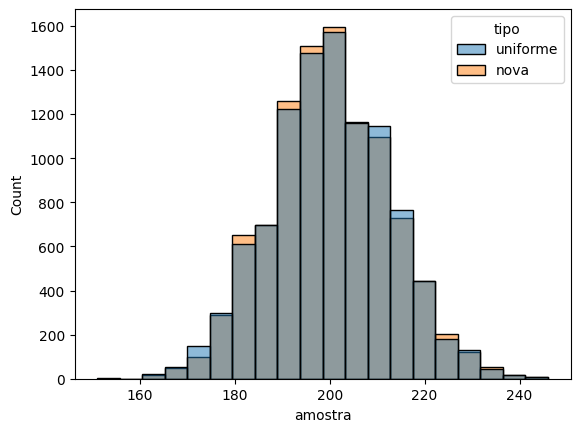

In [102]:
sns.histplot(data=df_8, x="amostra", hue="tipo", bins=20)

# Questão 9

### Ponto 1

Implementei um estimador simples para a integral de g(x)=e^(-x^2) no intervalo de \[0,1\]

In [42]:
def g(x):
    return math.e**(-x**2)

def integracao_monte_carlo(f, n):
    soma_mc = 0
    for i in range(n):
        soma_mc += f(rd.random())
    return soma_mc/n

In [43]:
integracao_monte_carlo(g, 100)

0.7451691308780747

### Ponto 2

Implementei um estimador utilizando Importance Sampling, utilizando h(x) = (e/(e-1)*e^(-x)

In [94]:
def h(x):
    return math.e**(1-x)/(math.e-1)

In [95]:
def inv_H(x):
    return -np.log(1-(x*(math.e-1)/math.e))

In [96]:
def amostra_h():
    return inv_H(rd.random())

In [97]:
def integracao_importance_sampling(n):
    soma_mc = 0
    for i in range(n):
        x = amostra_h()
        soma_mc += g(x)/h(x)
    return soma_mc/n

In [106]:
integracao_importance_sampling(100)

0.7504568992372129

### Ponto 3

Plotei um gráfico do erro relativo de cada um dos estimadores em função do número de amostras

In [107]:
integ_exato, _ = quad(g, 0, 1) # valor real
print(integ_exato)

0.7468241328124271


In [108]:
list_n = []
list_monte_carlo = []
list_importance_sampling = []
for i in range(1,7):
    n = 10**i
    list_n.append(n)
    list_monte_carlo.append(integracao_monte_carlo(g, n))
    list_importance_sampling.append(integracao_importance_sampling(n))

In [109]:
df_mc = pd.DataFrame({"n": list_n, "tipo": "monte_carlo", "estimador": list_monte_carlo})
df_is = pd.DataFrame({"n": list_n, "tipo": "importance_sampling", "estimador": list_importance_sampling})
df_8 = pd.concat([df_mc, df_is])
df_8["n"] = df_8["n"].astype(str)

In [110]:
df_8["estimador_erro"] = abs(df_8["estimador"]-integ_exato)/integ_exato

In [111]:
df_8

,n,tipo,estimador,estimador_erro
0,10,monte_carlo,0.813382,0.089122
1,100,monte_carlo,0.761032,0.019025
2,1000,monte_carlo,0.750198,0.004517
3,10000,monte_carlo,0.750750,0.005257
4,100000,monte_carlo,0.747872,0.001403
5,1000000,monte_carlo,0.746847,0.000030
0,10,importance_sampling,0.759446,0.016901
1,100,importance_sampling,0.751709,0.006540
2,1000,importance_sampling,0.747243,0.000560
3,10000,importance_sampling,0.746359,0.000623


<Axes: xlabel='n', ylabel='estimador_erro'>

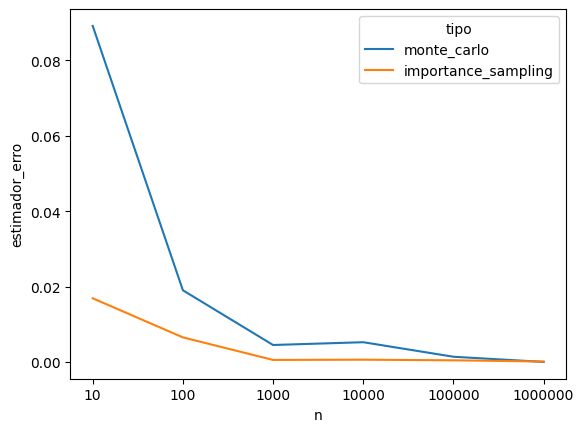

In [112]:
sns.lineplot(data = df_8, x="n", hue="tipo", y="estimador_erro")